In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import itertools
from BZI.symmetry import make_rptvecs, sym_path
import matplotlib.pyplot as plt

In [3]:
def sphere_pts(A,r2,offset):
    """ Calculate all the points within a sphere that are 
    given by an integer linear combination of the columns of 
    A.
    
    Args:
        A (numpy.ndarray): the grid basis with the columns 
            representing basis vectors.
        r2 (float): the squared radius of the sphere.
        offset(list or numpy.ndarray): a vector that points to the center
            of the sphere.
        
    Returns:
        grid (list): an array of grid coordinates in cartesian
            coordinates.
    """
    
    # This is a parameter that should help deal with rounding error.
    eps = 1e-9
    offset = np.asarray(offset)
    
    # Put the offset in lattice coordinates
    oi= np.round(np.dot(np.linalg.inv(A),offset))
    # Find a lattice point close to the offset
    oi = oi.astype(int)
    
    r = np.sqrt(r2)
    V = np.linalg.det(A)
    n = [0,0,0]
    for i in range(3):
        # Add 1 because the offset was rounded to the nearest lattice point.
        n[i] = int(np.ceil(np.linalg.norm(np.cross(A[:,(i+1)%3],A[:,(i+2)%3]))*r/V) + 1)

    grid = []
    for i,j,k in itertools.product(range(-n[0] + oi[0], n[0] + oi[0]),
                                   range(-n[1] + oi[1], n[1] + oi[1]),
                                   range(-n[2] + oi[2], n[2] + oi[2])):
        pt = np.dot(A,[i,j,k])
        if np.dot(pt-offset,pt-offset) <= r2 + eps:
            grid.append(pt)
        else:
            continue                
    return grid

In [46]:
def hollow_sphere_pts(A, r1, r2, offset):
    """ Calculate all the points between two spheres that are    
    given by an integer linear combination of the columns of
    A.
    
    Args:
        A (numpy.ndarray): the grid basis with the columns
            representing basis vectors.
        r1 (float): the squared radius of the interior sphere.
        r2 (float): the squared radius of the exterior sphere.
        offset(list or numpy.ndarray): a vector that points to the center
            of the sphere.
        
    Returns:
        grid (list): an array of grid coordinates in cartesian
            coordinates.
    """
    
    # This is a parameter that should help deal with rounding error.
    eps = 1e-9
    offset = np.asarray(offset)
    
    # Put the offset in lattice coordinates
    oi= np.round(np.dot(np.linalg.inv(A),offset))
    # Find a lattice point close to the offset
    oi = oi.astype(int)
    
    r = np.sqrt(r2)
    V = np.linalg.det(A)
    n = [0,0,0]
    for i in range(3):
        # Add 1 because the offset was rounded to the nearest lattice point.
        n[i] = int(np.ceil(np.linalg.norm(np.cross(A[:,(i+1)%3],A[:,(i+2)%3]))*r/V) + 1)

    grid = []
    for i,j,k in itertools.product(range(-n[0] + oi[0], n[0] + oi[0]),
                                   range(-n[1] + oi[1], n[1] + oi[1]),
                                   range(-n[2] + oi[2], n[2] + oi[2])):
        pt = np.dot(A,[i,j,k])
        if np.dot(pt-offset,pt-offset) <= r2:
            if np.dot(pt-offset,pt-offset) >= r1:
                grid.append(pt)
            else:
                continue     
        else:
            continue
    return grid

In [23]:
Si_lat_type = "fcc"
Si_lat_const = 10.26121 # the lattice constant in Bohr
Si_lat_vecs = make_rptvecs(Si_lat_type, Si_lat_const)
Si_tau = Si_lat_const/8.*np.array([1,1,1]) # one atomic basis vector
# The pseudopotential form factors of Si
Si_pff =   [-0.21, 0.04, 0.08]
# The cutoff energy for the fourier expansion of wavefunction
Si_r = 21.*(2*np.pi/Si_lat_const)**2

def SiPP(kpoint,neigvals,matrix=False):
    """Find the eigenvalues of a Hamiltonian matrix built to match the
    band structure of Si.
    
    Args:
        kpoint (list or numpy.ndarray): a point in k-space.
        neigvals (int): the number of returned eigenvalues in increasing
            order.
        matrix (bool): if true return the matrix instead.
        
    Returns:
        eigvals (np.ndarray): the eigenvalues of the Hamiltonian matrix.
        H (np.ndarray): if matrix is true, return the Hamiltonian matrix.
    """

    # rlat_pts = sphere_pts(Si_lat_vecs, Si_r, kpoint) # reciprocal lattice points
    rlat_pts = sphere_pts(Si_lat_vecs, Si_r, [0,0,0]) # reciprocal lattice points
    nrlat_pts = len(rlat_pts)
    H = np.zeros((nrlat_pts, nrlat_pts),dtype=complex)
    
    for i in range(nrlat_pts):
        for j in range(i + 1):
            h = (rlat_pts[j] - rlat_pts[i])
            if i == j:
                H[i,j] = np.dot(kpoint + rlat_pts[i], kpoint + rlat_pts[i])
            if np.isclose(np.dot(h,h), 3*(2*np.pi/Si_lat_const)**2):
                H[i,j] = Si_pff[0]*np.cos(np.dot(h,Si_tau))
            if np.isclose(np.dot(h,h), 8*(2*np.pi/Si_lat_const)**2):
                H[i,j] = Si_pff[1]*np.cos(np.dot(h,Si_tau))
            if np.isclose(np.dot(h,h), 11*(2*np.pi/Si_lat_const)**2):
                H[i,j] = Si_pff[2]*np.cos(np.dot(h,Si_tau))
            else:
                continue
            
    Ry_to_eV = 13.605698066
    energy_shift = 10.4864461
    if matrix:
        return H*Ry_to_eV - energy_shift
    else:
        return np.linalg.eigvalsh(H)[:neigvals]*Ry_to_eV - energy_shift

In [17]:
GaAs_lat_type = "fcc"
GaAs_lat_const = 10.65806 # the lattice constant in Bohr
GaAs_lat_vecs = make_rptvecs(GaAs_lat_type, GaAs_lat_const)
GaAs_tau = GaAs_lat_const/8.*np.array([1,1,1]) # one atomic basis vector
# The pseudopotential form factors of Si
GaAs_spff =   [-0.23, 0.01, 0.06]
GaAs_aspff =   [0.07, 0.05, 0.01]
# The cutoff energy for the fourier expansion of wavefunction
GaAs_r = 21.*(2*np.pi/GaAs_lat_const)**2

def GaAsPP(kpoint,neigvals,matrix=False):
    """Find the eigenvalues of a Hamiltonian matrix built to match the
    band structure of Si.
    
    Args:
        kpoint (list or numpy.ndarray): a point in k-space.
        neigvals (int): the number of returned eigenvalues in increasing
            order.
        matrix (bool): if true return the matrix instead.
        
    Returns:
        eigvals (np.ndarray): the eigenvalues of the Hamiltonian matrix.
        H (np.ndarray): if matrix is true, return the Hamiltonian matrix.
    """
    
    rlat_pts = sphere_pts(GaAs_lat_vecs, GaAs_r, kpoint) # reciprocal lattice points
    # rlat_pts = sphere_pts(GaAs_lat_vecs, GaAs_r, [0,0,0]) # reciprocal lattice points    
    nrlat_pts = len(rlat_pts)
    H = np.zeros((nrlat_pts, nrlat_pts),dtype=complex)
    
    for i in range(nrlat_pts):
        for j in range(i+1):
            h = (rlat_pts[j] - rlat_pts[i])
            if i == j:
                H[i,j] = np.dot(kpoint + rlat_pts[i], kpoint + rlat_pts[i])
            if np.isclose(np.dot(h,h), 3*(2*np.pi/GaAs_lat_const)**2):
                H[i,j] = GaAs_spff[0]*np.cos(np.dot(h,GaAs_tau)) + (
                            1j*GaAs_aspff[0]*np.sin(np.dot(h,GaAs_tau)))
            if np.isclose(np.dot(h,h), 8*(2*np.pi/GaAs_lat_const)**2):
                H[i,j] = GaAs_spff[1]*np.cos(np.dot(h,GaAs_tau)) + (
                            1j*GaAs_aspff[1]*np.sin(np.dot(h,GaAs_tau)))
            if np.isclose(np.dot(h,h), 11*(2*np.pi/GaAs_lat_const)**2):
                H[i,j] = GaAs_spff[2]*np.cos(np.dot(h,GaAs_tau)) + (
                            1j*GaAs_aspff[2]*np.sin(np.dot(h,GaAs_tau)))
            else:
                pass
    Ry_to_eV = 13.605698066
    energy_shift = 9.35709861
    if matrix:
        return H*Ry_to_eV - energy_shift
    else:
        return np.linalg.eigvalsh(H)[:neigvals]*Ry_to_eV - energy_shift

#### Plot the band structure of Si.

In [42]:
def plot_bandstructure(material, npts):
    """Plot the band structure.
    
    Args:
        material (string): a string indicating which pseudopotenial
            to implement.
        npts (float): the number of points for each symmetry path.    
    """

    if material == "Si":
        PP = SiPP
        lat_const = 10.26121
    elif material == "GaAs":
        PP = GaAsPP
        lat_const = 10.65806
    elif material == "New":
        PP = newSiPP
        lat_const = 10.26121
    else:
        raise InputError("Invalid material provided")

    sympt_pairs = [("L","G"),("G","X"),("X","U"),("U","G2")]
    lat_type = "fcc"
    rlat_vecs = make_rptvecs(lat_type, lat_const)
    
    # The k-points between symmetry points in reciprocal lattice coordinates.
    lat_kpoints = sym_path(lat_type,npts,sympt_pairs)
    
    # The k-points between symmetry points in cartesian coordinates.
    car_kpoints = [np.dot(rlat_vecs,k) for k in lat_kpoints]
    
    # Place all eigenvalues in a nested list.
    energies = []
    nbands = 8
    for kpt in car_kpoints:
        energies.append(PP(kpt, nbands))
    # Grad the symmetry points.
    L = np.array(car_kpoints[0])
    G = np.array(car_kpoints[npts-1])
    X = np.array(car_kpoints[2*(npts-1)])
    K = np.array(car_kpoints[3*(npts-1)])
    G2 = np.array(car_kpoints[4*(npts-1)])

    # Find the distances between symmetry points.
    l1 = np.linalg.norm(G - L)
    l2 = np.linalg.norm(X - G)
    l3 = np.linalg.norm(K - X)
    l4 = np.linalg.norm(G2 - K)
    ltot = l1 + l2 + l3 + l4

    # Create x-coordinates used for plotting that go from
    # 0 to the sum of symmetry path lengths. 
    # Unfortunately shorter symmetry paths with have higher resolution.
    line1 = list(np.delete(np.linspace(0,l1,npts),-1))
    line2 = list(np.delete(np.linspace(l1,l1+l2,npts),-1))
    line3 = list(np.delete(np.linspace(l1+l2,l1+l2+l3,npts),-1))
    line4 = list(np.linspace(l1+l2+l3,l1+l2+l3+l4,npts))
    lines = line1 + line2 + line3 + line4

    # Plot the energy dispersion curves one at a time.
    for nb in range(nbands):
        ienergy = []
        for nk in range(len(car_kpoints)):
            ienergy.append(energies[nk][nb])
        plt.plot(lines, ienergy, color="black")
#         if nb == 0:
#             plt.plot(lines, ienergy, color="black", label="Band structure")
#         else:
#             plt.plot(lines, ienergy, color="black")

    # Plot a vertical line at the symmetry points with proper labels
    plt.axvline(x = l1, c="gray")
    plt.axvline(x = l1 + l2, c="gray")
    plt.axvline(x = l1 + l2 + l3, c="gray")
    plt.axvline(x = l1 + l2 + l3 + l4, c="gray")
    tick_labels = ["L", "$\Gamma$", "X", "K", "$\Gamma$"]
    tick_locs = [0, l1, l1 + l2, l1 + l2 + l3, l1 + l2 + l3 + l4]

    plt.xticks(tick_locs,tick_labels)
    plt.yticks(range(-5,8,1),range(-5,8,1))
    plt.ylim([-4, 7])
    plt.xlim([0,ltot])
    plt.xlabel("Symmetry points")
    plt.ylabel("Energy (eV)")
    plt.title("%s Band Structure"%material)
    plt.grid(linestyle="dotted")
    plt.show()
    # lgd = plt.legend(loc='center left', bbox_to_anchor=(.115, .09),fancybox=True)
    # lgd.get_frame().set_alpha(0.2)
    # plt.savefig("%s_band_struct.pdf" %material)#, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=1000,transparent=True)
    # plt.show()
    # plt.close()

### Let's try again using perturbation theory.

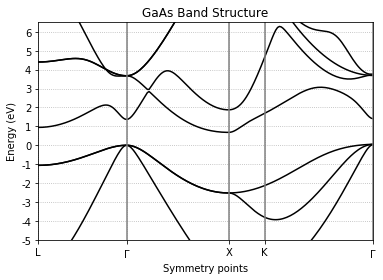

In [43]:
plot_bandstructure("GaAs",60)

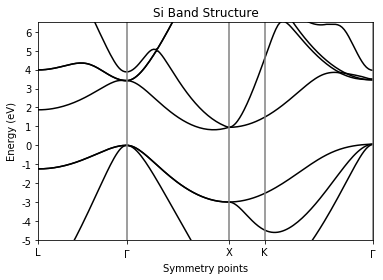

In [38]:
plot_bandstructure("Si",50)

In [50]:
Si_lat_type = "fcc"
Si_lat_const = 10.26121 # the lattice constant in Bohr
Si_lat_vecs = make_rptvecs(Si_lat_type, Si_lat_const)
Si_tau = Si_lat_const/8.*np.array([1,1,1]) # one atomic basis vector
# The pseudopotential form factors of Si
Si_pff = [-0.21, 0.04, 0.08]
# The cutoff energy for the fourier expansion of wavefunction
Si_r1 = 7.*(2*np.pi/Si_lat_const)**2
Si_r2 = 21.*(2*np.pi/Si_lat_const)**2
Si_rlat_pts1 = sphere_pts(Si_lat_vecs, Si_r1, [0,0,0]) # reciprocal lattice points
Si_rlat_pts2 = hollow_sphere_pts(Si_lat_vecs, Si_r1, Si_r2, [0,0,0]) # reciprocal lattice points
Ry_to_eV = 13.605698066
Si_energy_shift = 10.4864461


def newSiPP(kpoint,neigvals,matrix=False):
    """Find the eigenvalues of a Hamiltonian matrix built to match the
    band structure of Si.
    
    Args:
        kpoint (list or numpy.ndarray): a point in k-space.
        neigvals (int): the number of returned eigenvalues in increasing
            order.
        matrix (bool): if true return the matrix instead.
        
    Returns:
        eigvals (np.ndarray): the eigenvalues of the Hamiltonian matrix.
        H (np.ndarray): if matrix is true, return the Hamiltonian matrix.
    """

    Si_r1 = 7.*(2*np.pi/Si_lat_const)**2
    Si_r2 = 21.*(2*np.pi/Si_lat_const)**2
    Si_rlat_pts1 = sphere_pts(Si_lat_vecs, Si_r1, kpoint) # reciprocal lattice points
    Si_rlat_pts2 = hollow_sphere_pts(Si_lat_vecs, Si_r1, Si_r2, kpoint) # reciprocal lattice points
    nrlat_pts1 = len(Si_rlat_pts1)
    nrlat_pts2 = len(Si_rlat_pts2)
    H = np.zeros((nrlat_pts1, nrlat_pts1),dtype=complex)
    
    for i in range(nrlat_pts1):
        for j in range(nrlat_pts1):
            h = (Si_rlat_pts1[j] - Si_rlat_pts1[i])
            if i == j:
                H[i,j] = np.dot(kpoint + Si_rlat_pts1[i], kpoint + Si_rlat_pts1[i])
            if np.isclose(np.dot(h,h), 3*(2*np.pi/Si_lat_const)**2):
                H[i,j] = Si_pff[0]*np.cos(np.dot(h,Si_tau))
            if np.isclose(np.dot(h,h), 8*(2*np.pi/Si_lat_const)**2):
                H[i,j] = Si_pff[1]*np.cos(np.dot(h,Si_tau))
            if np.isclose(np.dot(h,h), 11*(2*np.pi/Si_lat_const)**2):
                H[i,j] = Si_pff[2]*np.cos(np.dot(h,Si_tau))
            else:
                pass
            
    eigs = np.linalg.eigvalsh(H) # *Ry_to_eV - Si_energy_shift
    E = np.sum(eigs)/len(eigs)

    for i in range(nrlat_pts1):
        for j in range(nrlat_pts1):
            C = 0
            for k in range(nrlat_pts2):
                h_ki = (Si_rlat_pts2[k] - Si_rlat_pts1[i])
                h_jk = (Si_rlat_pts1[j] - Si_rlat_pts2[k])
                H_kk = np.dot(kpoint + Si_rlat_pts2[k], kpoint + Si_rlat_pts2[k])
                
                if np.allclose(h_ki,[0,0,0]):
                    H_ki = np.dot(kpoint + Si_rlat_pts1[i], kpoint + Si_rlat_pts1[i])
                elif np.isclose(np.dot(h_ki,h_ki), 3*(2*np.pi/Si_lat_const)**2):
                    H_ki = Si_pff[0]*np.cos(np.dot(h_ki, Si_tau))
                elif np.isclose(np.dot(h_ki,h_ki), 8*(2*np.pi/Si_lat_const)**2):
                    H_ki = Si_pff[1]*np.cos(np.dot(h_ki, Si_tau))
                elif np.isclose(np.dot(h_ki,h_ki), 11*(2*np.pi/Si_lat_const)**2):
                    H_ki = Si_pff[2]*np.cos(np.dot(h_ki, Si_tau))
                else:
                    H_ki = 0.
                
                if np.allclose(h_jk,[0,0,0]):
                    H_jk = np.dot(kpoint + Si_rlat_pts1[j], kpoint + Si_rlat_pts1[j])
                elif np.isclose(np.dot(h_jk,h_jk), 3*(2*np.pi/Si_lat_const)**2):
                    H_jk = Si_pff[0]*np.cos(np.dot(h_jk, Si_tau))
                elif np.isclose(np.dot(h_jk,h_jk), 8*(2*np.pi/Si_lat_const)**2):
                    H_jk = Si_pff[1]*np.cos(np.dot(h_jk, Si_tau))
                elif np.isclose(np.dot(h_jk,h_jk), 11*(2*np.pi/Si_lat_const)**2):
                    H_jk = Si_pff[2]*np.cos(np.dot(h_jk, Si_tau))
                else:
                    H_jk = 0.
                C += H_ki*H_jk/(E - H_kk)                            
            H[i,j] += C
    if matrix:
        return H*Ry_to_eV - Si_energy_shift
    else:
        return np.linalg.eigvalsh(H)[:neigvals]*Ry_to_eV - Si_energy_shift
    

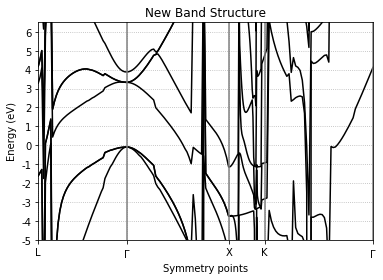

In [51]:
plot_bandstructure("New", 50)

In [1]:
a = [("L","G"),("G","X"),("X","U"),("U","G2")]

In [5]:
b = [item for sublist in a for item in sublist]

In [15]:
b

['L', 'G', 'G', 'X', 'X', 'U', 'U', 'G2']

In [16]:
sorted(set(b),key=b.index)

['L', 'G', 'X', 'U', 'G2']

In [35]:
a = list(range(5))
a

[0, 1, 2, 3, 4]

In [36]:
import numpy as np
np.sum(a[:1])

0

In [44]:
a = 0.0
if a:
    print(a)